In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

# Train attention model

In [2]:
from fastai.conv_learner import *
# import pixiedust
from matplotlib.patches import Rectangle
from datetime import datetime
import pandas as pd

import torch
from layers import *
from constant import CLASS_NAMES
from transform import chest_xray_transfrom
from metrics import *
import pretrainedmodels
from recorder import TrainingRecoder
import pretrainedmodels
from dataset import ChestXray14Dataset
from model_data import ModelData
from chexnet import ChexNet
from utils import get_chestxray_from_csv

In [3]:
PATH = Path('/home/dattran/data/xray-thesis/chestX-ray14')
IMAGE_DN = 'tmp/attention'
TRAIN_CSV = 'train.csv'
VAL_CSV = 'val.csv'
TEST_CSV = 'test.csv'

percentage = 1
WORKERS = 6

N_CLASSES = 14
models_name = datetime.strftime(datetime.now(), '%Y%m%d-%H%M%S')

model_path = PATH/'models'/models_name
model_path.mkdir(parents=True, exist_ok=True)
print('Model name', models_name)

Model name 20190204-224709


In [4]:
# the model we use not include sigmoid as last layer
def acc_s(preds, targs):
    return accuracy_multi(torch.sigmoid(preds), targs, 0.5)

def auc_s(preds, targs):
    return auc(torch.sigmoid(preds), targs)

## Load dataset

In [6]:
def get_chestxray_from_csv():
    result = []
    for f in [PATH/TRAIN_CSV, PATH/VAL_CSV, PATH/TEST_CSV]:
        df = pd.read_csv(f, sep=' ', header=None)
        images = df.iloc[:, 0].values
        labels = df.iloc[:, 1:].values
        result.append((images, labels))
    return result

def get_md(sz, bs, percentage):
    data = get_chestxray_from_csv()
    tfms = chest_xray_transfrom(sz, 0.875)
    datasets = ImageData.get_ds(ChestXray14Dataset, trn=data[0], val=data[1], test=data[2], tfms=tfms, path=PATH/IMAGE_DN, size=sz, percentage=percentage)
    md = ModelData(PATH/IMAGE_DN, datasets, bs, WORKERS, CLASS_NAMES)
    return md

md = get_md(224, 128, percentage)

## Densenet121 arch with binary classification

In [8]:
class CheXNetModel():
    
    def __init__(self, chexnet):
        self.model = chexnet
    
    def get_layer_groups(self, precompute):
        lgs = list(split_by_idxs(children(self.model.backbone), [8]))
        lgs += [children(self.model.head)]
        return lgs

chexnet = to_gpu(ChexNet(model_name='20180429-130928')) # use chexnet as pretrain model
chexnet_model = CheXNetModel(chexnet)
learn = ConvLearner(md, chexnet_model, models_name=model_path) # train in mixed percision
# learn.crit = WeightedBCEWithLogitsLoss()
learn.crit = nn.BCEWithLogitsLoss()

In [ ]:
### Warning ###

# Find lr for last layer groups

In [7]:
# learn.lr_find()

epoch      trn_loss   val_loss                               
    0      0.614568   2.582748  

epoch      trn_loss   val_loss   
    0      0.614568   2.582748  



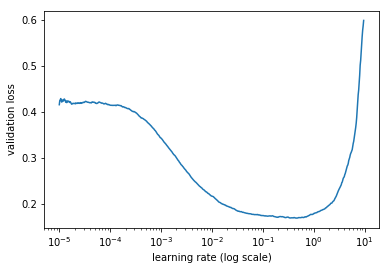

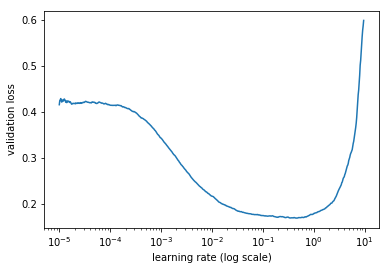

In [8]:
# learn.sched.plot(0, 0)

# Lr find for all layer group

In [9]:
# md = get_md(224, 16, percentage)
# learn.set_data(md)
# learn.unfreeze()
# learn.lr_find()

epoch      trn_loss   val_loss                                 
    0      0.196268   0.261272  

epoch      trn_loss   val_loss   
    0      0.196268   0.261272  



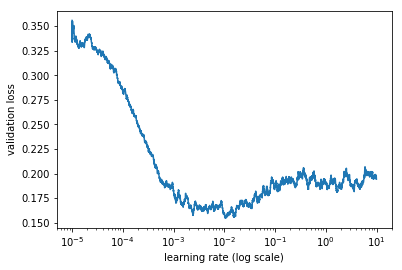

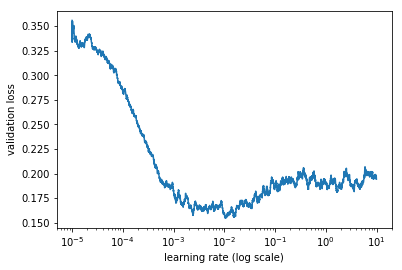

In [10]:
# learn.sched.plot(0, 0)

# Training

In [15]:
def train_last_layer(learn, loss_recorder, n_cycle, lr=1e-4):
    print(f'Train last layer group with {n_cycle} cycle, lr={lr}')
    learn.freeze_to(-1)
    md = get_md(224, 128, percentage)
    learn.set_data(md)
    layer_opt = learn.get_layer_opt(lr, None)
    loss_recorder.new_phase(layer_opt)
    learn.sched = None
    learn.fit_gen(learn.model, learn.data, layer_opt, n_cycle, \
                  metrics=[auc_s, acc_s], cycle_len=1, use_clr=(8, 10), \
                  callbacks=[loss_recorder], best_save_name='best')
    
def train_all_layer(learn, loss_recorder, n_cycle, lr=8e-3):
    print(f'Train every groups with {n_cycle} cycle, lr={lr}')
    lrs = [lr/1000, lr/100, lr]
    learn.unfreeze()
    md = get_md(224, 64, percentage)
    learn.set_data(md)
    layer_opt = learn.get_layer_opt(lrs, None)
    loss_recorder.new_phase(layer_opt)
    learn.sched = None
    learn.fit_gen(learn.model, learn.data, layer_opt, n_cycle, \
                  metrics=[auc_s, acc_s], cycle_len=1, use_clr=(8, 10), \
                  callbacks=[loss_recorder], best_save_name='best')


In [8]:
loss_recorder = TrainingRecoder(model_path)
train_last_layer(learn, loss_recorder, 50, lr=2e-3)
train_all_layer(learn, loss_recorder, 50, lr=1e-4)
loss_recorder.save()

Train last layer group with 1 cycle, lr=0.0001


14                                                         
epoch      trn_loss   val_loss   auc_s      acc_s      
    0      0.57349    0.53969    0.496944   0.83516   

Train every groups with 1 cycle, lr=0.0001


14                                                           
epoch      trn_loss   val_loss   auc_s      acc_s      
    0      0.390087   0.36522    0.499788   0.952976  



In [11]:
def sigmoid_np(x):
    return 1. / (1. + np.exp(-x))

py, y = learn.TTA()
print(auc_np(sigmoid_np(np.mean(py, axis=0)), y))

Test
Test
0.775233589778711                            
0.775233589778711
